# Multivariate Probabilistic Time Series Forecasting with informer with causal data set

In [7]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def run_linear_regression(data, feature_cols, target_col, test_ratio=0.2):

    """
    Run linear regression on the provided dataset.

    Parameters:
    data (DataFrame): The input data containing features and target.
    feature_cols (list): The names of the columns to be used as features.
    target_col (str): The name of the column to be used as the target.
    test_ratio (float): The proportion of the dataset to include in the test split.

    Returns:
    model: The trained Linear Regression model.
    mse: Mean Squared Error of the model on the test set.
    mae: Mean Absolute Error of the model on the test set.
    """
    data.index = data['date']
    # Split the data by index for a time series prediction context
    test_size = int(len(data) * test_ratio)
    train_data = data.iloc[:-test_size]
    test_data = data.iloc[-test_size:]

    X_train = train_data[feature_cols]
    Y_train = train_data[target_col]
    X_test = test_data[feature_cols]
    Y_test = test_data[target_col]

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X_train, Y_train)

    # Predict on the test set
    Y_pred = model.predict(X_test)

    # Calculate error metrics
    mse = mean_squared_error(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(Y_test.index, Y_test, label='Actual Values', color='blue')
    plt.plot(Y_test.index, Y_pred, label='Predicted Values', color='red')
    plt.title('Linear Regression Predictions vs Actual')
    plt.xlabel('Index')
    plt.ylabel(target_col)
    plt.legend()
    plt.show()

    # Print error metrics
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")

    return model, mse, mae



In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :-1])
        Y.append(data[i + look_back - 1, -1])
    return np.array(X), np.array(Y)

def run_lstm(data, feature_cols, target_col, test_ratio=0.2, look_back=1, epochs=100, batch_size=1):
    """
    Run LSTM on the provided dataset.

    Parameters:
    data (DataFrame): The input data containing features and target.
    feature_cols (list): The names of the columns to be used as features.
    target_col (str): The name of the column to be used as the target.
    test_ratio (float): The proportion of the dataset to include in the test split.
    look_back (int): The number of previous time steps to use as input for predicting the next time step.
    epochs (int): The number of epochs to train the LSTM model.
    batch_size (int): The batch size for training the LSTM model.

    Returns:
    model: The trained LSTM model.
    mse: Mean Squared Error of the model on the test set.
    mae: Mean Absolute Error of the model on the test set.
    """
    data.index = data['date']
    data = data.drop('date', axis=1)

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Split the data by index for a time series prediction context
    test_size = int(len(data) * test_ratio)
    train_data = scaled_data[:-test_size]
    test_data = scaled_data[-test_size:]
    # print(train_data)
    # print(test_data)
    # Create the training and testing datasets
    X_train, Y_train = create_dataset(train_data, look_back)
    X_test, Y_test = create_dataset(test_data, look_back)
   
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, len(feature_cols))))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the LSTM model
    model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=2)

    # Predict on the test set
    Y_pred = model.predict(X_test)

    # Inverse transform the predictions and actual values
    Y_pred = scaler.inverse_transform(np.concatenate((np.zeros((len(Y_pred), len(feature_cols))), Y_pred), axis=1))[:, -1]
    Y_test = scaler.inverse_transform(np.concatenate((np.zeros((len(Y_test), len(feature_cols))), Y_test.reshape(-1, 1)), axis=1))[:, -1]
    print(Y_pred)
    # Calculate error metrics
    mse = mean_squared_error(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(Y_test)), Y_test, label='Actual Values', color='blue')
    plt.plot(range(len(Y_pred)), Y_pred, label='Predicted Values', color='red')
    plt.title('LSTM Predictions vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel(target_col)
    plt.legend()
    plt.show()

    # Print error metrics
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")

    return model, mse, mae


# Dataset with 3 variables + noise, 1 confounding one (LINEAR)

In [3]:
np.random.seed(42)

In [9]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

def generate_data(seq_length=1000):
    # Generate the confounder C
    C = np.random.normal(loc=0, scale=1, size=seq_length)
    
    # Prepare timestamps
    start_date = datetime.strptime('01/07/2016 02:00', '%d/%m/%Y %H:%M')
    timestamps = [start_date + timedelta(hours=i) for i in range(seq_length)]
    # Generate X influenced by C
    X = np.sin(C) #+ np.random.normal(loc=0, scale=0.2, size=seq_length)
    # Generate Y influenced by X and C in a non-linear way
    Y = np.square(X) + np.cos(C) #+ np.random.normal(loc=0, scale=0.2, size=seq_length)

    # Create DataFrame
    data_df = pd.DataFrame({
        'date': timestamps,
        '0': C,
        '1': X,
        'OT': Y #OT is the target
    })
    return data_df

# Set the desired number of rows


# Generate and save the data
data_df = generate_data(seq_length=10000) # Set the desired number of rows #26304 SAME as autofromer electricity dataset
data_df_simple_linear = data_df.copy()
#data_df.to_csv('data_causal_1.csv', index=False)


In [42]:
data_df_simple_linear


,date,0,1,OT
0,2016-07-01 02:00:00,-0.461399,-0.445201,1.093635
1,2016-07-01 03:00:00,0.173346,0.172479,1.014762
2,2016-07-01 04:00:00,0.340831,0.334271,1.054214
3,2016-07-01 05:00:00,-0.883012,-0.772655,1.231822
4,2016-07-01 06:00:00,0.077622,0.077544,1.003002
...,...,...,...,...
9995,2017-08-21 13:00:00,-0.864367,-0.760685,1.227763
9996,2017-08-21 14:00:00,0.981457,0.831308,1.246885
9997,2017-08-21 15:00:00,0.219219,0.217467,1.023360
9998,2017-08-21 16:00:00,-0.281840,-0.278123,1.037898


## Incorporating Daily or Weekly Patterns

In [14]:
def generate_data(seq_length=1000):
    # Generate the confounder C
    C = np.random.normal(loc=0, scale=1, size=seq_length)
    
    # Prepare timestamps
    start_date = datetime.strptime('01/07/2016 02:00', '%d/%m/%Y %H:%M')
    timestamps = [start_date + timedelta(hours=i) for i in range(seq_length)]
    
    # Generate patterns and trend
    daily_pattern = np.sin(2 * np.pi * np.arange(seq_length) / 24)
    weekly_pattern = np.sin(2 * np.pi * np.arange(seq_length) / (24 * 7))
    linear_trend = np.linspace(0, 2, seq_length)
    
    # Generate X influenced by C, with patterns and trend
    X = np.sin(C) + 0.5 * daily_pattern + 0.3 * weekly_pattern + 0.1 * linear_trend + np.random.normal(loc=0, scale=0.2, size=seq_length)
    
    # Generate Y influenced by X and C, with patterns and trend
    Y = np.square(X) + np.cos(C) + 0.4 * daily_pattern + 0.2 * weekly_pattern + 0.2 * linear_trend + np.random.normal(loc=0, scale=0.2, size=seq_length)
    
    # Create DataFrame
    data_df = pd.DataFrame({
        'date': timestamps,
        '0': C,
        '1': X,
        'OT': Y  # OT is the target
    })
    
    return data_df

In [22]:
data = generate_data(seq_length=1000)


Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


799/799 - 1s - 1ms/step - loss: 0.0253
Epoch 2/30
799/799 - 0s - 489us/step - loss: 0.0174
Epoch 3/30
799/799 - 0s - 483us/step - loss: 0.0166
Epoch 4/30
799/799 - 0s - 478us/step - loss: 0.0162
Epoch 5/30
799/799 - 0s - 567us/step - loss: 0.0157
Epoch 6/30
799/799 - 0s - 486us/step - loss: 0.0152
Epoch 7/30
799/799 - 0s - 518us/step - loss: 0.0148
Epoch 8/30
799/799 - 0s - 519us/step - loss: 0.0146
Epoch 9/30
799/799 - 0s - 487us/step - loss: 0.0137
Epoch 10/30
799/799 - 0s - 568us/step - loss: 0.0130
Epoch 11/30
799/799 - 0s - 487us/step - loss: 0.0122
Epoch 12/30
799/799 - 0s - 485us/step - loss: 0.0108
Epoch 13/30
799/799 - 0s - 485us/step - loss: 0.0100
Epoch 14/30
799/799 - 0s - 486us/step - loss: 0.0085
Epoch 15/30
799/799 - 0s - 514us/step - loss: 0.0076
Epoch 16/30
799/799 - 0s - 567us/step - loss: 0.0068
Epoch 17/30
799/799 - 0s - 484us/step - loss: 0.0062
Epoch 18/30
799/799 - 0s - 485us/step - loss: 0.0057
Epoch 19/30
799/799 - 0s - 483us/step - loss: 0.0050
Epoch 20/30
799

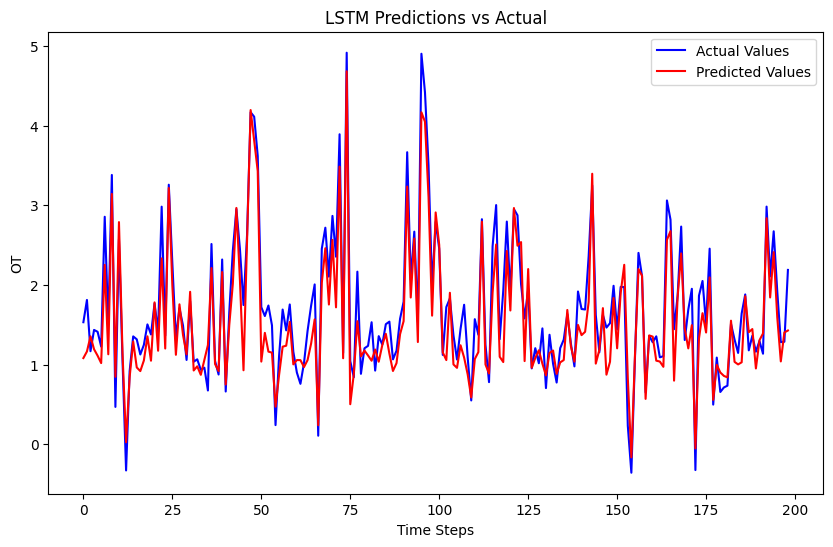

Mean Squared Error: 0.10392513635978862
Mean Absolute Error: 0.25829969168557804


(<Sequential name=sequential_4, built=True>,
 0.10392513635978862,
 0.25829969168557804)

In [23]:
run_lstm(data, ['0', '1'], 'OT', look_back=1, test_ratio=0.2, epochs=30, batch_size=1)



In [ ]:
data.index = data['date']
data = data.drop('date', axis=1)
test_ratio=0.2
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data by index for a time series prediction context
test_size = int(len(data) * test_ratio)
train_data = scaled_data[:-test_size]
test_data = scaled_data[-test_size:]
# print(train_data)
# print(test_data)
# Create the training and testing datasets
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15999/15999 - 8s - 526us/step - loss: 0.0213
Epoch 2/10
15999/15999 - 8s - 493us/step - loss: 0.0136
Epoch 3/10
15999/15999 - 7s - 468us/step - loss: 0.0027
Epoch 4/10
15999/15999 - 7s - 464us/step - loss: 1.5771e-04
Epoch 5/10
15999/15999 - 7s - 456us/step - loss: 1.4995e-04
Epoch 6/10
15999/15999 - 7s - 462us/step - loss: 1.4851e-04
Epoch 7/10
15999/15999 - 7s - 457us/step - loss: 1.3735e-04
Epoch 8/10
15999/15999 - 7s - 457us/step - loss: 1.3946e-04
Epoch 9/10
15999/15999 - 7s - 465us/step - loss: 1.2442e-04
Epoch 10/10
15999/15999 - 7s - 461us/step - loss: 1.2658e-04
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[1.21343836 1.18553104 1.2496689  ... 1.24330777 1.09769542 0.96436588]


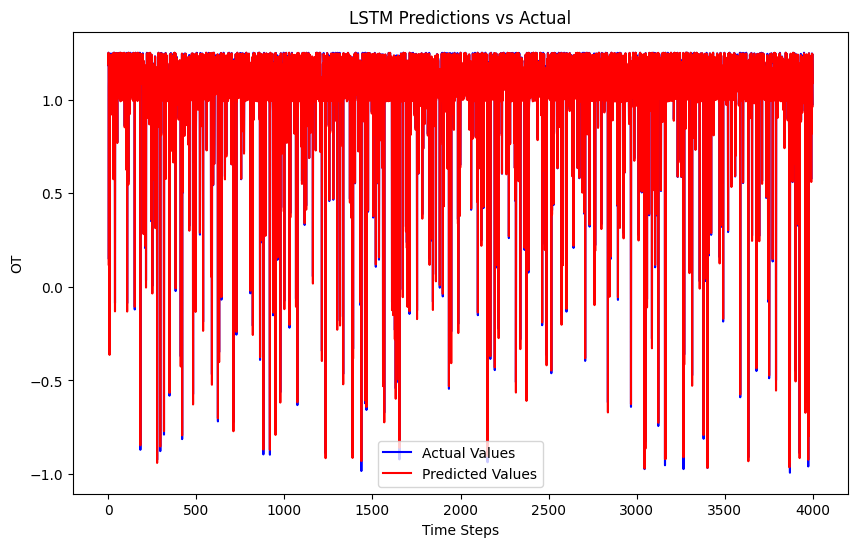

Mean Squared Error: 9.155980121889738e-05
Mean Absolute Error: 0.006053316589480101


(<Sequential name=sequential_13, built=True>,
 9.155980121889738e-05,
 0.006053316589480101)

In [50]:
run_lstm(data_df_simple_linear, ['0', '1'], 'OT', look_back=1, test_ratio=0.2, epochs=10, batch_size=1)



X_train shape: (799, 1, 2), Y_train shape: (799,)
X_test shape: (199, 1, 2), Y_test shape: (199,)
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


799/799 - 1s - 2ms/step - loss: 0.0243 - val_loss: 0.0193
Epoch 2/10
799/799 - 0s - 552us/step - loss: 0.0131 - val_loss: 0.0211
Epoch 3/10
799/799 - 0s - 555us/step - loss: 0.0132 - val_loss: 0.0190
Epoch 4/10
799/799 - 1s - 642us/step - loss: 0.0128 - val_loss: 0.0220
Epoch 5/10
799/799 - 0s - 554us/step - loss: 0.0134 - val_loss: 0.0194
Epoch 6/10
799/799 - 0s - 550us/step - loss: 0.0129 - val_loss: 0.0198
Epoch 7/10
799/799 - 0s - 549us/step - loss: 0.0129 - val_loss: 0.0194
Epoch 8/10
799/799 - 0s - 547us/step - loss: 0.0132 - val_loss: 0.0190
Epoch 9/10
799/799 - 1s - 641us/step - loss: 0.0128 - val_loss: 0.0193
Epoch 10/10
799/799 - 0s - 557us/step - loss: 0.0133 - val_loss: 0.0194
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Y_pred (first 5): [1.11949184 1.1095654  1.1320564  1.10255371 1.11492904]
Y_test (first 5): [-0.6783669   1.13094258  1.59268305  1.1635247   0.8482804 ]


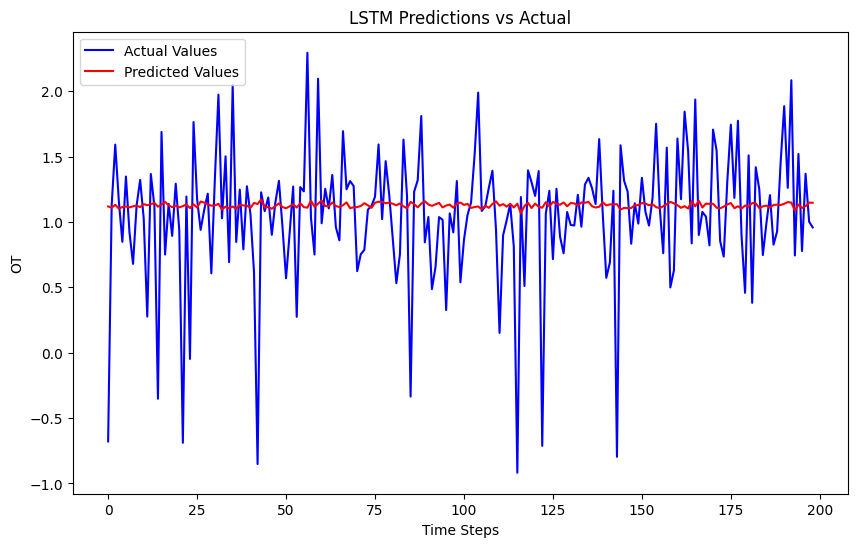

Mean Squared Error: 0.2718316861369947
Mean Absolute Error: 0.35200160672998243


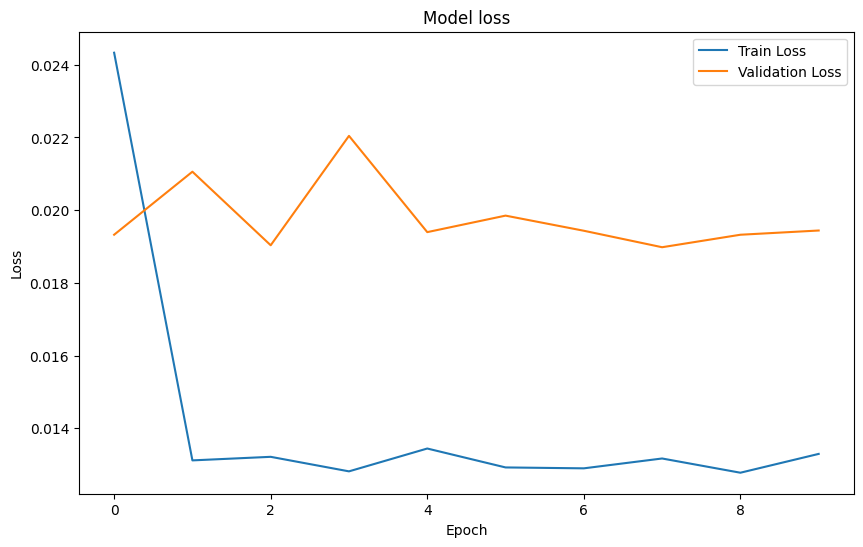

(<Sequential name=sequential_7, built=True>,
 0.2718316861369947,
 0.35200160672998243)

In [30]:
run_lstm(data_df_simple_linear, ['0', '1'], 'OT', look_back=1, test_ratio=0.2, epochs=10, batch_size=1)


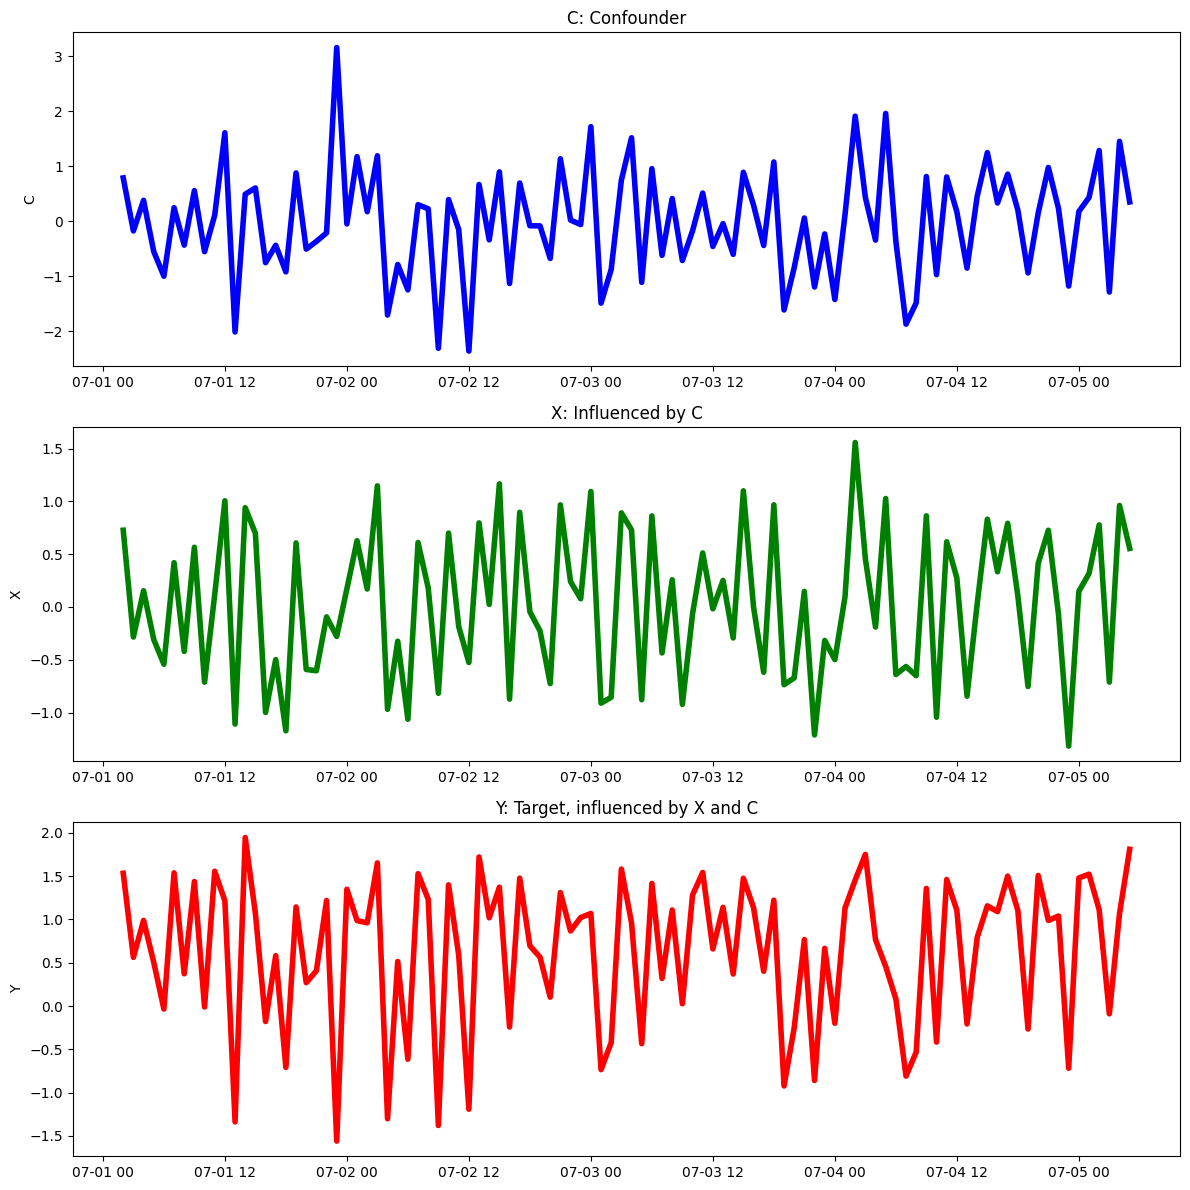

In [36]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Define the provided function
def generate_data(seq_length=1000):
    # Generate the confounder C
    C = np.random.normal(loc=0, scale=1, size=seq_length)
    
    # Prepare timestamps
    start_date = datetime.strptime('01/07/2016 02:00', '%d/%m/%Y %H:%M')
    timestamps = [start_date + timedelta(hours=i) for i in range(seq_length)]
    # Generate X influenced by C
    X = np.sin(C) + np.random.normal(loc=0, scale=0.2, size=seq_length)
    # Generate Y influenced by X and C in a non-linear way
    Y = X + np.cos(C) + np.random.normal(loc=0, scale=0.2, size=seq_length)

    # Create DataFrame
    data_df = pd.DataFrame({
        'date': timestamps,
        'C': C,
        'X': X,
        'Y': Y # OT is the target
    })
    return data_df

# Generate the data
data_df = generate_data(seq_length=100)  # Using the full 1000 data points

# Plotting C, X, and Y
fig, axes = plt.subplots(3, 1, figsize=(12, 12), facecolor='white')

# Plot C
axes[0].plot(data_df['date'], data_df['C'], color='blue', linewidth=4)
axes[0].set_title('C: Confounder')
axes[0].set_ylabel('C')

# Plot X
axes[1].plot(data_df['date'], data_df['X'], color='green', linewidth=4)
axes[1].set_title('X: Influenced by C')
axes[1].set_ylabel('X')

# Plot Y
axes[2].plot(data_df['date'], data_df['Y'], color='red', linewidth=4)
axes[2].set_title('Y: Target, influenced by X and C')
axes[2].set_ylabel('Y')

plt.tight_layout()
plt.show()


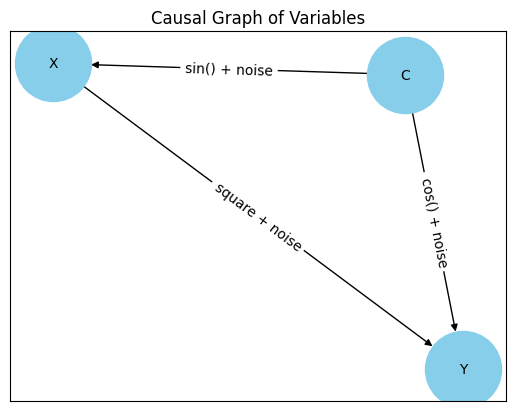

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

# Creating a directed graph
G = nx.DiGraph()

# Adding nodes and edges based on the causal relationships in the code
G.add_edge('C', 'X', label='sin() + noise')
G.add_edge('C', 'Y', label='cos() + noise')
G.add_edge('X', 'Y', label='square + noise')

# Graph layout
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, node_color='skyblue', node_size=3000, font_size=10, font_color="black")
labels = nx.get_edge_attributes(G,'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title('Causal Graph of Variables')
plt.show()


In [4]:
# data_df_simple_linear.index = data_df_simple_linear['date']
# plt.figure(figsize=(10, 6))
# plt.plot(data_df_simple_linear.index, data_df_simple_linear["OT"], label='Actual Values', color='blue')
# plt.show()

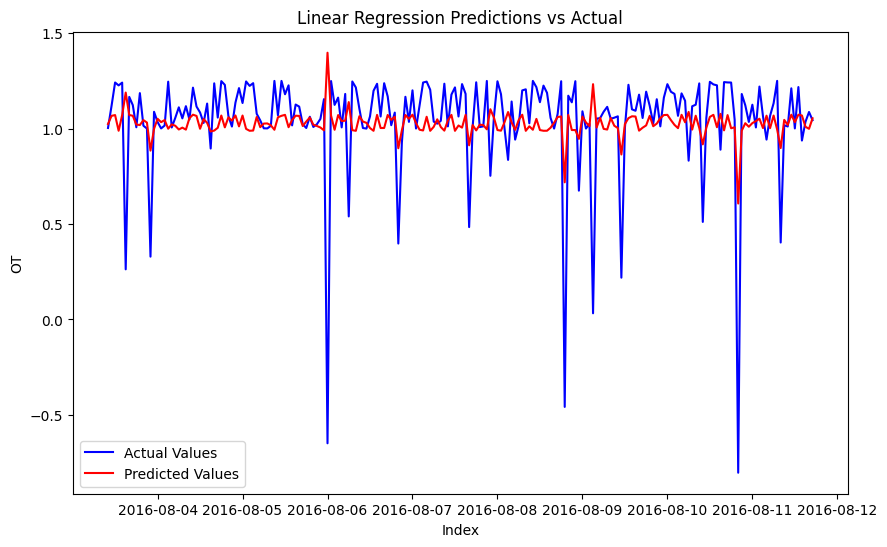

Mean Squared Error: 0.07630429906172216
Mean Absolute Error: 0.15200597939633959


(LinearRegression(), 0.07630429906172216, 0.15200597939633959)

In [37]:
run_linear_regression(data_df_simple_linear, ['0', '1'], 'OT', test_ratio=0.2)


Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


799/799 - 1s - 1ms/step - loss: 0.0324
Epoch 2/30
799/799 - 0s - 482us/step - loss: 0.0136
Epoch 3/30
799/799 - 0s - 470us/step - loss: 0.0135
Epoch 4/30
799/799 - 0s - 466us/step - loss: 0.0135
Epoch 5/30
799/799 - 0s - 461us/step - loss: 0.0133
Epoch 6/30
799/799 - 0s - 470us/step - loss: 0.0131
Epoch 7/30
799/799 - 0s - 467us/step - loss: 0.0129
Epoch 8/30
799/799 - 0s - 491us/step - loss: 0.0131
Epoch 9/30
799/799 - 0s - 472us/step - loss: 0.0129
Epoch 10/30
799/799 - 0s - 489us/step - loss: 0.0126
Epoch 11/30
799/799 - 0s - 487us/step - loss: 0.0125
Epoch 12/30
799/799 - 0s - 474us/step - loss: 0.0121
Epoch 13/30
799/799 - 0s - 475us/step - loss: 0.0118
Epoch 14/30
799/799 - 0s - 469us/step - loss: 0.0117
Epoch 15/30
799/799 - 0s - 484us/step - loss: 0.0114
Epoch 16/30
799/799 - 0s - 466us/step - loss: 0.0109
Epoch 17/30
799/799 - 0s - 479us/step - loss: 0.0105
Epoch 18/30
799/799 - 0s - 466us/step - loss: 0.0101
Epoch 19/30
799/799 - 0s - 466us/step - loss: 0.0097
Epoch 20/30
799

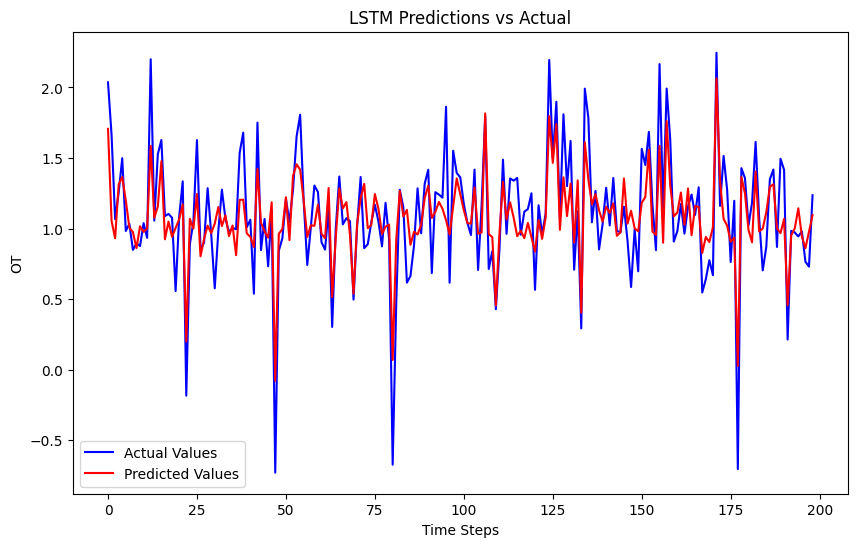

Mean Squared Error: 0.05934235318088878
Mean Absolute Error: 0.18559626589569095


(<Sequential name=sequential, built=True>,
 0.05934235318088878,
 0.18559626589569095)

In [8]:
run_lstm(data_df_simple_linear, ['0', '1'], 'OT', look_back=1, test_ratio=0.2, epochs=30, batch_size=1)

In [36]:
#OLD ONE run_lstm_multifeature(data_df_simple_linear, ['0', '1'], 'OT', look_back=4, test_ratio=0.2)

# Dataset with 3 variables + noise, 1 confounding one (LINEAR)  with Autocorrelations and Lagged Variables

In [43]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

def generate_data(seq_length=1000):
    # Generate the confounder C
    C = np.random.normal(loc=0, scale=1, size=seq_length)
    
    # Prepare timestamps
    start_date = datetime.strptime('01/07/2016 02:00', '%d/%m/%Y %H:%M')
    timestamps = [start_date + timedelta(hours=i) for i in range(seq_length)]
    
    # Initialize X with initial random values
    X = np.zeros(seq_length)
    X[0] = np.random.normal()
    
    # Generate X with autocorrelation and influence by C
    for i in range(1, seq_length):
        X[i] = 0.7 * X[i-1] + np.sin(C[i]) + np.random.normal(loc=0, scale=0.2)
    
    # Initialize Y with initial random values
    Y = np.zeros(seq_length)
    Y[0] = np.random.normal()
    
    # Generate Y influenced by current and lagged X and current C
    for i in range(1, seq_length):
        Y[i] = 0.5 * Y[i-1] + np.square(X[i]) + 0.3 * np.square(X[i-1]) + np.cos(C[i]) + np.random.normal(loc=0, scale=0.2)
    
    # Create DataFrame
    data_df = pd.DataFrame({
        'date': timestamps,
        '0': C,
        '1': X,
        'OT': Y  # Y is the target
    })
    return data_df

# Generate and save the data
data_df = generate_data(seq_length=1000)
df_linear_autocorrelations = data_df.copy()
data_df.to_csv('data_with_autocorrelations.csv', index=False)


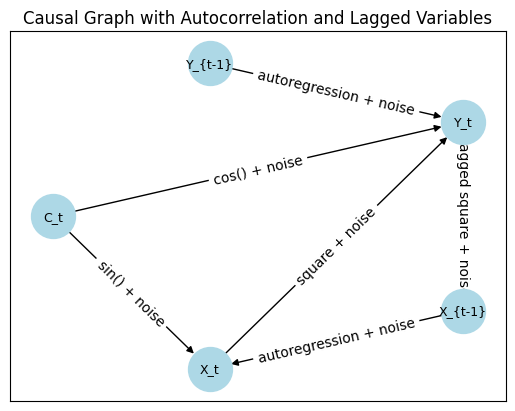

In [12]:
# Creating a directed graph for the updated causal model with autocorrelation and lagged variables
G_updated = nx.DiGraph()

# Adding nodes and edges based on the causal relationships in the updated code
G_updated.add_edge('C_t', 'X_t', label='sin() + noise')
G_updated.add_edge('X_{t-1}', 'X_t', label='autoregression + noise')
G_updated.add_edge('C_t', 'Y_t', label='cos() + noise')
G_updated.add_edge('X_t', 'Y_t', label='square + noise')
G_updated.add_edge('X_{t-1}', 'Y_t', label='lagged square + noise')
G_updated.add_edge('Y_{t-1}', 'Y_t', label='autoregression + noise')

# Graph layout
pos_updated = nx.shell_layout(G_updated)
nx.draw_networkx(G_updated, pos_updated, with_labels=True, node_color='lightblue', node_size=1000, font_size=9, font_color="black")
labels_updated = nx.get_edge_attributes(G_updated,'label')
nx.draw_networkx_edge_labels(G_updated, pos_updated, edge_labels=labels_updated)
plt.title('Causal Graph with Autocorrelation and Lagged Variables')
plt.show()


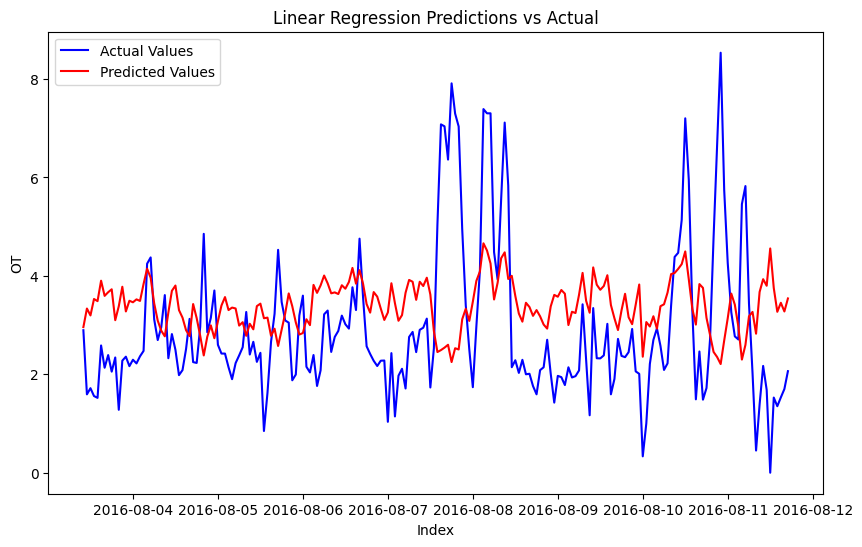

Mean Squared Error: 2.8761614303374974
Mean Absolute Error: 1.3475686123390889


(LinearRegression(), 2.8761614303374974, 1.3475686123390889)

In [52]:
run_linear_regression(df_linear_autocorrelations, ['0', '1'], 'OT', test_ratio=0.2)


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :-1])
        Y.append(data[i + look_back - 1, -1])
    return np.array(X), np.array(Y)

def run_lstm(data, feature_cols, target_col, test_ratio=0.2, look_back=1, epochs=100, batch_size=1):
    """
    Run LSTM on the provided dataset.

    Parameters:
    data (DataFrame): The input data containing features and target.
    feature_cols (list): The names of the columns to be used as features.
    target_col (str): The name of the column to be used as the target.
    test_ratio (float): The proportion of the dataset to include in the test split.
    look_back (int): The number of previous time steps to use as input for predicting the next time step.
    epochs (int): The number of epochs to train the LSTM model.
    batch_size (int): The batch size for training the LSTM model.

    Returns:
    model: The trained LSTM model.
    mse: Mean Squared Error of the model on the test set.
    mae: Mean Absolute Error of the model on the test set.
    """
    data.index = data['date']
    data = data.drop('date', axis=1)

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Split the data by index for a time series prediction context
    test_size = int(len(data) * test_ratio)
    train_data = scaled_data[:-test_size]
    test_data = scaled_data[-test_size:]
    # print(train_data)
    # print(test_data)
    # Create the training and testing datasets
    X_train, Y_train = create_dataset(train_data, look_back)
    X_test, Y_test = create_dataset(test_data, look_back)
   
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, len(feature_cols))))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the LSTM model
    model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=2)

    # Predict on the test set
    Y_pred = model.predict(X_test)

    # Inverse transform the predictions and actual values
    Y_pred = scaler.inverse_transform(np.concatenate((np.zeros((len(Y_pred), len(feature_cols))), Y_pred), axis=1))[:, -1]
    Y_test = scaler.inverse_transform(np.concatenate((np.zeros((len(Y_test), len(feature_cols))), Y_test.reshape(-1, 1)), axis=1))[:, -1]
    print(Y_pred)
    # Calculate error metrics
    mse = mean_squared_error(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(Y_test)), Y_test, label='Actual Values', color='blue')
    plt.plot(range(len(Y_pred)), Y_pred, label='Predicted Values', color='red')
    plt.title('LSTM Predictions vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel(target_col)
    plt.legend()
    plt.show()

    # Print error metrics
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")

    return model, mse, mae



Epoch 1/30


c:\Users\flori\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


799/799 - 5s - 6ms/step - loss: 0.0204
Epoch 2/30
799/799 - 2s - 3ms/step - loss: 0.0189
Epoch 3/30
799/799 - 2s - 2ms/step - loss: 0.0186
Epoch 4/30
799/799 - 1s - 2ms/step - loss: 0.0187
Epoch 5/30
799/799 - 3s - 3ms/step - loss: 0.0185
Epoch 6/30
799/799 - 2s - 2ms/step - loss: 0.0181
Epoch 7/30
799/799 - 2s - 3ms/step - loss: 0.0179
Epoch 8/30
799/799 - 1s - 1ms/step - loss: 0.0175
Epoch 9/30
799/799 - 1s - 1ms/step - loss: 0.0173
Epoch 10/30
799/799 - 1s - 2ms/step - loss: 0.0166
Epoch 11/30
799/799 - 1s - 2ms/step - loss: 0.0158
Epoch 12/30
799/799 - 1s - 2ms/step - loss: 0.0147
Epoch 13/30
799/799 - 1s - 2ms/step - loss: 0.0131
Epoch 14/30
799/799 - 2s - 3ms/step - loss: 0.0119
Epoch 15/30
799/799 - 2s - 3ms/step - loss: 0.0105
Epoch 16/30
799/799 - 2s - 2ms/step - loss: 0.0094
Epoch 17/30
799/799 - 2s - 2ms/step - loss: 0.0086
Epoch 18/30
799/799 - 2s - 3ms/step - loss: 0.0081
Epoch 19/30
799/799 - 2s - 3ms/step - loss: 0.0077
Epoch 20/30
799/799 - 2s - 3ms/step - loss: 0.0074


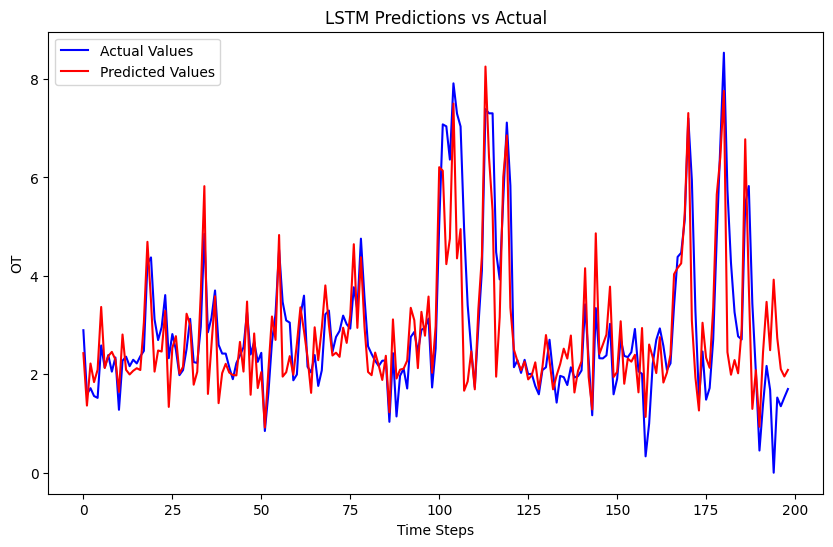

Mean Squared Error: 0.8067192150357737
Mean Absolute Error: 0.6099474622371607


(<Sequential name=sequential_12, built=True>,
 0.8067192150357737,
 0.6099474622371607)

In [49]:
run_lstm(df_linear_autocorrelations, ['0', '1'], 'OT', look_back=1, test_ratio=0.2, epochs=30, batch_size=1)

# Dataset with 3 variables + noise, 1 confounding one (NON-LINEAR)

In [54]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

def generate_data(seq_length=1000):
    # Generate the confounder C
    C = np.random.normal(loc=0, scale=1, size=seq_length)
    
    # Prepare timestamps
    start_date = datetime.strptime('01/07/2016 02:00', '%d/%m/%Y %H:%M')
    timestamps = [start_date + timedelta(hours=i) for i in range(seq_length)]
    
    # Generate X influenced by C
    X = np.sin(C) + np.random.normal(loc=0, scale=0.8, size=seq_length)
    # Generate Y influenced by X and C in a non-linear way
    Y = np.square(X) * np.cos(C) + np.random.normal(loc=0, scale=0.8, size=seq_length)
    
    # Create DataFrame
    data_df = pd.DataFrame({
        'date': timestamps,
        '0': C,
        '1': X,
        'OT': Y
    })
    return data_df

# Generate data
# Generate and save the data
data_df = generate_data(seq_length=1000) # Set the desired number of rows
data_df_simple_nonlinear= data_df.copy()
# TO CSV data_df.to_csv('data_causal_2.csv', index=False)



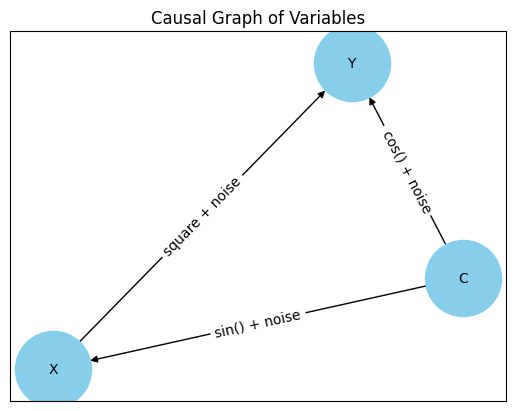

In [15]:
import matplotlib.pyplot as plt
import networkx as nx

# Creating a directed graph
G = nx.DiGraph()

# Adding nodes and edges based on the causal relationships in the code
G.add_edge('C', 'X', label='sin() + noise')
G.add_edge('C', 'Y', label='cos() + noise')
G.add_edge('X', 'Y', label='square + noise')

# Graph layout
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, node_color='skyblue', node_size=3000, font_size=10, font_color="black")
labels = nx.get_edge_attributes(G,'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title('Causal Graph of Variables')
plt.show()


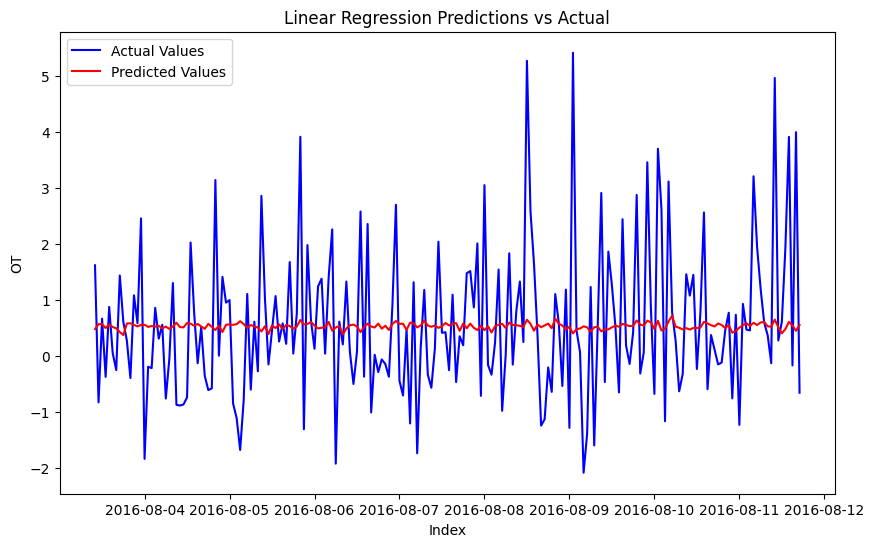

Mean Squared Error: 1.7861602484717494
Mean Absolute Error: 1.0092118649672532


(LinearRegression(), 1.7861602484717494, 1.0092118649672532)

In [55]:
run_linear_regression(data_df_simple_nonlinear, ['0', '1'], 'OT')

Epoch 1/30


c:\Users\flori\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


799/799 - 3s - 4ms/step - loss: 0.0153
Epoch 2/30
799/799 - 2s - 2ms/step - loss: 0.0085
Epoch 3/30
799/799 - 1s - 1ms/step - loss: 0.0084
Epoch 4/30
799/799 - 1s - 2ms/step - loss: 0.0081
Epoch 5/30
799/799 - 1s - 2ms/step - loss: 0.0082
Epoch 6/30
799/799 - 1s - 2ms/step - loss: 0.0082
Epoch 7/30
799/799 - 1s - 2ms/step - loss: 0.0081
Epoch 8/30
799/799 - 1s - 2ms/step - loss: 0.0080
Epoch 9/30
799/799 - 1s - 2ms/step - loss: 0.0079
Epoch 10/30
799/799 - 1s - 2ms/step - loss: 0.0080
Epoch 11/30
799/799 - 1s - 2ms/step - loss: 0.0078
Epoch 12/30
799/799 - 1s - 2ms/step - loss: 0.0078
Epoch 13/30
799/799 - 1s - 2ms/step - loss: 0.0078
Epoch 14/30
799/799 - 2s - 2ms/step - loss: 0.0076
Epoch 15/30
799/799 - 1s - 2ms/step - loss: 0.0076
Epoch 16/30
799/799 - 1s - 1ms/step - loss: 0.0074
Epoch 17/30
799/799 - 1s - 2ms/step - loss: 0.0073
Epoch 18/30
799/799 - 2s - 2ms/step - loss: 0.0073
Epoch 19/30
799/799 - 2s - 2ms/step - loss: 0.0071
Epoch 20/30
799/799 - 1s - 2ms/step - loss: 0.0070


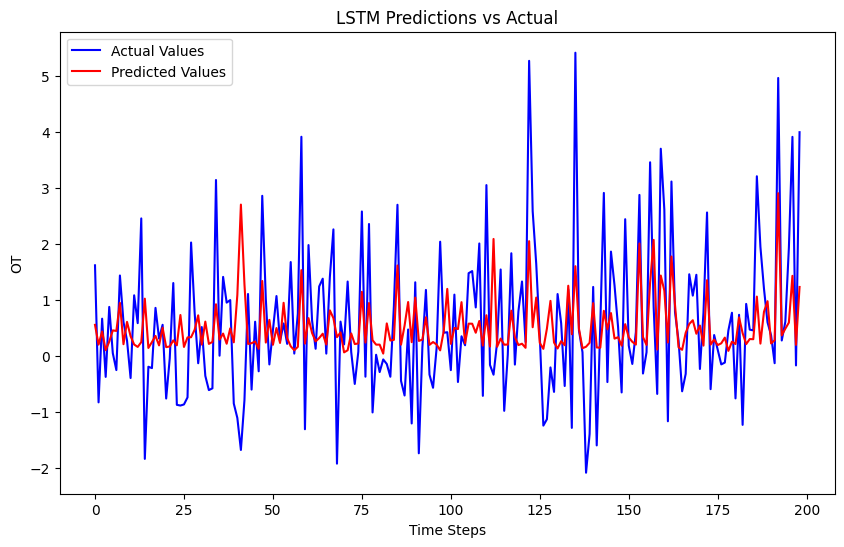

Mean Squared Error: 1.3428361666120299
Mean Absolute Error: 0.8870166656160177


(<Sequential name=sequential_13, built=True>,
 1.3428361666120299,
 0.8870166656160177)

In [56]:
run_lstm(data_df_simple_nonlinear, ['0', '1'], 'OT', look_back=1, test_ratio=0.2, epochs=30, batch_size=1)

# Dataset with 5 variables + noise, 1 confounding one, 2 without causal impact

In [57]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

def generate_data(seq_length=1000):
    # Generate the confounder C
    C = np.random.normal(loc=0, scale=1, size=seq_length)
    
    # Prepare timestamps
    start_date = datetime.strptime('01/07/2016 02:00', '%d/%m/%Y %H:%M')
    timestamps = [start_date + timedelta(hours=i) for i in range(seq_length)]
    
    # Generate X influenced by C
    X = np.sin(C) + np.random.normal(loc=0, scale=0.2, size=seq_length)
    # Generate Y influenced by X and C in a non-linear way
    Y = np.square(X) + np.cos(C) + np.random.normal(loc=0, scale=0.2, size=seq_length)

    D = np.random.normal(loc=0, scale=0.8, size=seq_length) + np.sin(C) #no causal impact on traget Y (OT)
    E = np.square(X) * np.cos(C) + np.random.normal(loc=0, scale=0.8, size=seq_length)
    C = np.random.normal(loc=0, scale=1, size=seq_length)
    

    # Create DataFrame
    data_df = pd.DataFrame({
        'date': timestamps,
        '0': C,
        '1': X,
        '2': D,
        '3': E,
        'OT': Y #OT is the target, influenced by C & X
    })
    return data_df

# Set the desired number of rows


# Generate and save the data
data_df = generate_data(seq_length=1000) # Set the desired number of rows
data_df.to_csv('data_causal_4.csv', index=False)

data_df_complex_linear = data_df.copy()

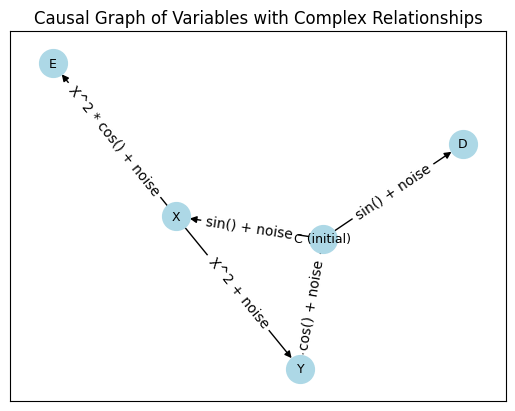

In [64]:
import matplotlib.pyplot as plt
import networkx as nx

# Creating a directed graph with new relationships
G_complex = nx.DiGraph()

# Adding nodes and edges based on the causal relationships in the updated code
G_complex.add_edge('C (initial)', 'X', label='sin() + noise')
G_complex.add_edge('C (initial)', 'Y', label='cos() + noise')
G_complex.add_edge('C (initial)', 'D', label='sin() + noise')
G_complex.add_edge('X', 'Y', label='X^2 + noise')
G_complex.add_edge('X', 'E', label='X^2 * cos() + noise')

# Graph layout
pos_complex = nx.spring_layout(G_complex)
nx.draw_networkx(G_complex, pos_complex, with_labels=True, node_color='lightblue', node_size=400, font_size=9, font_color="black")
labels_complex = nx.get_edge_attributes(G_complex, 'label')
nx.draw_networkx_edge_labels(G_complex, pos_complex, edge_labels=labels_complex)
plt.title('Causal Graph of Variables with Complex Relationships')
plt.show()


In [181]:
# data_df_complex_linear.index = data_df_complex_linear['date']
# plt.figure(figsize=(10, 6))
# plt.plot(data_df_complex_linear.index, data_df_complex_linear["OT"], label='Actual Values', color='blue')
# plt.show()

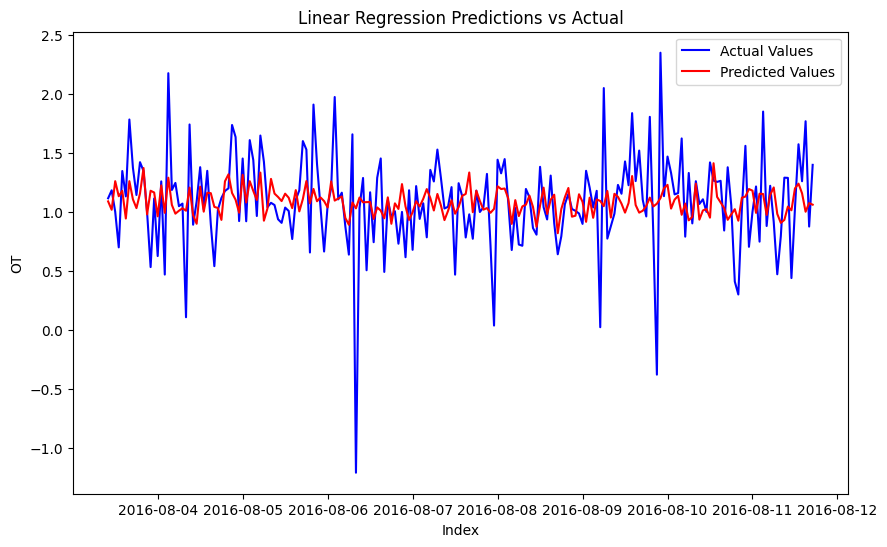

Mean Squared Error: 0.15095461456934184
Mean Absolute Error: 0.2716167572031593


(LinearRegression(), 0.15095461456934184, 0.2716167572031593)

In [58]:
run_linear_regression(data_df_complex_linear, ['0', '1', '2', '3'], 'OT')

Epoch 1/30


c:\Users\flori\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


799/799 - 3s - 4ms/step - loss: 0.0327
Epoch 2/30
799/799 - 1s - 2ms/step - loss: 0.0139
Epoch 3/30
799/799 - 2s - 2ms/step - loss: 0.0137
Epoch 4/30
799/799 - 3s - 3ms/step - loss: 0.0135
Epoch 5/30
799/799 - 2s - 3ms/step - loss: 0.0134
Epoch 6/30
799/799 - 2s - 3ms/step - loss: 0.0133
Epoch 7/30
799/799 - 1s - 2ms/step - loss: 0.0134
Epoch 8/30
799/799 - 1s - 2ms/step - loss: 0.0132
Epoch 9/30
799/799 - 1s - 2ms/step - loss: 0.0132
Epoch 10/30
799/799 - 2s - 2ms/step - loss: 0.0131
Epoch 11/30
799/799 - 2s - 2ms/step - loss: 0.0131
Epoch 12/30
799/799 - 3s - 3ms/step - loss: 0.0129
Epoch 13/30
799/799 - 2s - 2ms/step - loss: 0.0129
Epoch 14/30
799/799 - 2s - 2ms/step - loss: 0.0126
Epoch 15/30
799/799 - 2s - 2ms/step - loss: 0.0126
Epoch 16/30
799/799 - 2s - 2ms/step - loss: 0.0125
Epoch 17/30
799/799 - 3s - 3ms/step - loss: 0.0121
Epoch 18/30
799/799 - 2s - 3ms/step - loss: 0.0122
Epoch 19/30
799/799 - 2s - 2ms/step - loss: 0.0121
Epoch 20/30
799/799 - 2s - 3ms/step - loss: 0.0120


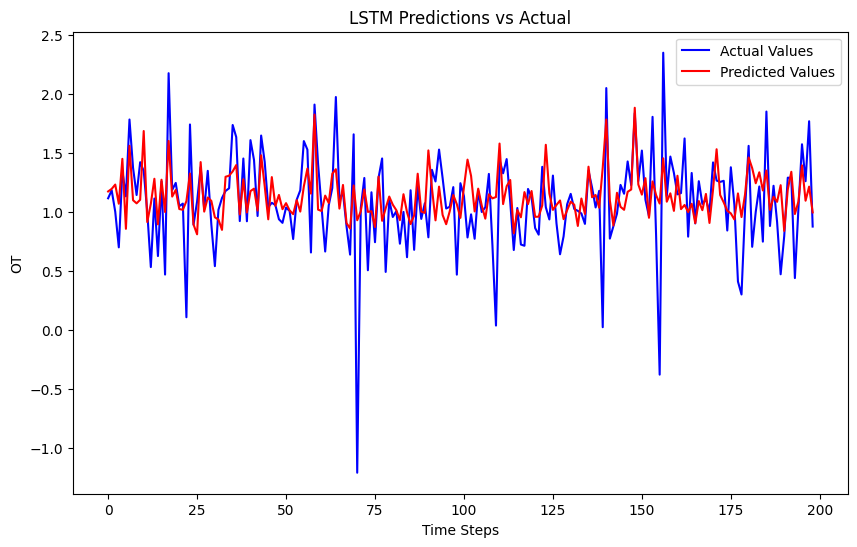

Mean Squared Error: 0.13088579799382544
Mean Absolute Error: 0.24401101333117453


(<Sequential name=sequential_15, built=True>,
 0.13088579799382544,
 0.24401101333117453)

In [60]:
run_lstm(data_df_complex_linear, ['0', '1', '2', '3'], 'OT', look_back=1, test_ratio=0.2, epochs=30, batch_size=1)

## Baselines!

## data_df_simple_linear

In [63]:
data_df_simple_linear

,date,0,1,OT
0,2016-07-01 02:00:00,0.966673,0.740733,1.479669
1,2016-07-01 03:00:00,0.932879,-1.017586,1.592570
2,2016-07-01 04:00:00,0.725855,0.967657,2.684124
3,2016-07-01 05:00:00,0.382565,1.117871,2.704597
4,2016-07-01 06:00:00,-0.421994,0.172615,0.472115
...,...,...,...,...
995,2016-08-11 13:00:00,0.202893,0.281713,0.660074
996,2016-08-11 14:00:00,-2.254518,-0.240322,-1.030998
997,2016-08-11 15:00:00,-0.314002,-0.088476,0.310916
998,2016-08-11 16:00:00,0.884794,-0.054337,-0.992856


In [70]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def run_linear_regression(data, feature_cols, target_col, test_ratio=0.2):
    """
    Run linear regression on the provided dataset.

    Parameters:
    data (DataFrame): The input data containing features and target.
    feature_cols (list): The names of the columns to be used as features.
    target_col (str): The name of the column to be used as the target.
    test_ratio (float): The proportion of the dataset to include in the test split.

    Returns:
    model: The trained Linear Regression model.
    mse: Mean Squared Error of the model on the test set.
    mae: Mean Absolute Error of the model on the test set.
    """
    data.index = data['date']
    # Split the data by index for a time series prediction context
    test_size = int(len(data) * test_ratio)
    train_data = data.iloc[:-test_size]
    test_data = data.iloc[-test_size:]

    X_train = train_data[feature_cols]
    Y_train = train_data[target_col]
    X_test = test_data[feature_cols]
    Y_test = test_data[target_col]

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X_train, Y_train)

    # Predict on the test set
    Y_pred = model.predict(X_test)

    # Calculate error metrics
    mse = mean_squared_error(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(Y_test.index, Y_test, label='Actual Values', color='blue')
    plt.plot(Y_test.index, Y_pred, label='Predicted Values', color='red')
    plt.title('Linear Regression Predictions vs Actual')
    plt.xlabel('Index')
    plt.ylabel(target_col)
    plt.legend()
    plt.show()

    # Print error metrics
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")

    return model, mse, mae



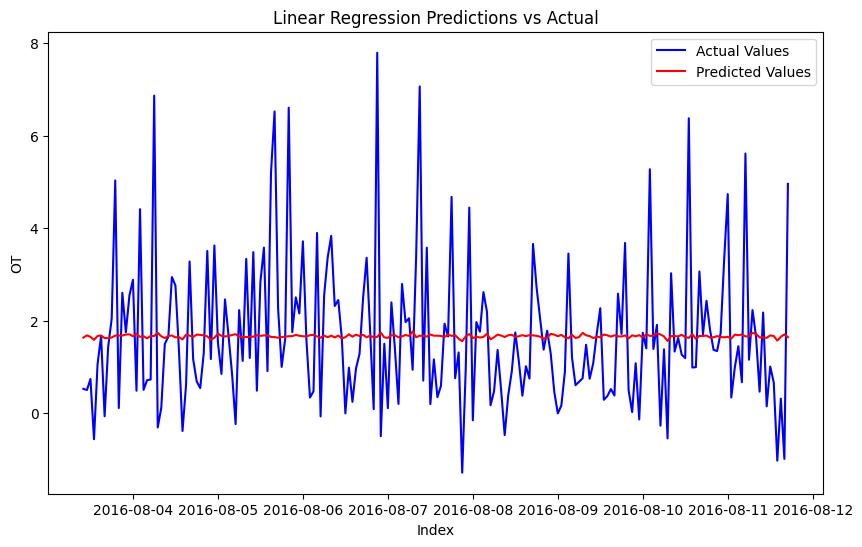

Mean Squared Error: 2.5313751680681587
Mean Absolute Error: 1.1813410350086615


(LinearRegression(), 2.5313751680681587, 1.1813410350086615)

In [71]:
run_linear_regression(data_df_simple_linear, ['0', '1'], 'OT')

Mean Squared Error: 2.869499696118694
Mean Absolute Error: 1.2415997055924057


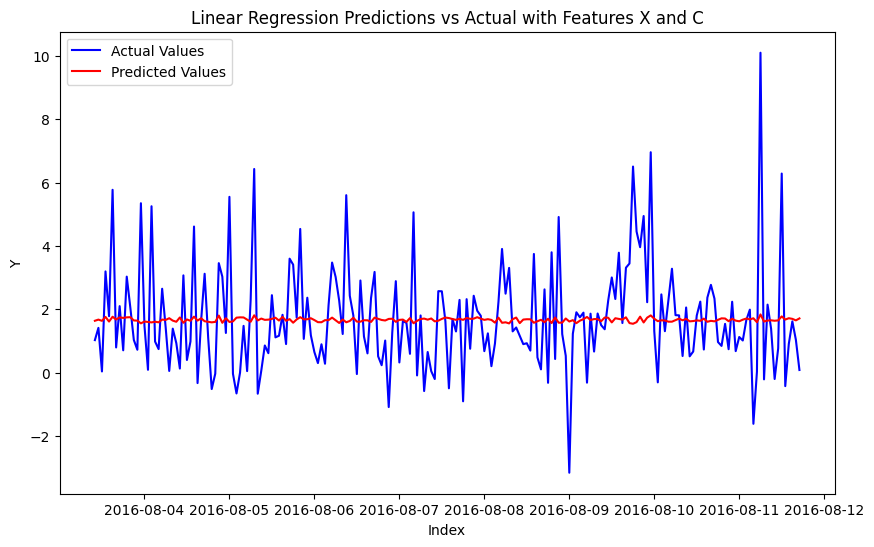

In [79]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load your dataset
data = data_df_simple_linear.copy() # Update path as necessary
data.index = data["date"]
# Select features and target
X = data[['0', '1']]
Y = data['OT']

# Define the size of the test set
test_size = int(len(data) * 0.2)  # e.g., 20% of the data as test set

# Split the data by index for a time series prediction context
train_data = data.iloc[:-test_size]
test_data = data.iloc[-test_size:]

X_train = train_data[['0', '1']]
Y_train = train_data['OT']
X_test = test_data[['0', '1']]
Y_test = test_data['OT']

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# Predict on the test set
Y_pred = model.predict(X_test)

# Calculate error metrics
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)

# Print error metrics
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(Y_test.index, Y_test, label='Actual Values', color='blue')
plt.plot(Y_test.index, Y_pred, label='Predicted Values', color='red')
plt.title('Linear Regression Predictions vs Actual with Features X and C')
plt.xlabel('Index')
plt.ylabel('Y')
plt.legend()
plt.show()


Mean Squared Error: 1.644891152896642
Mean Absolute Error: 1.0106338398733021


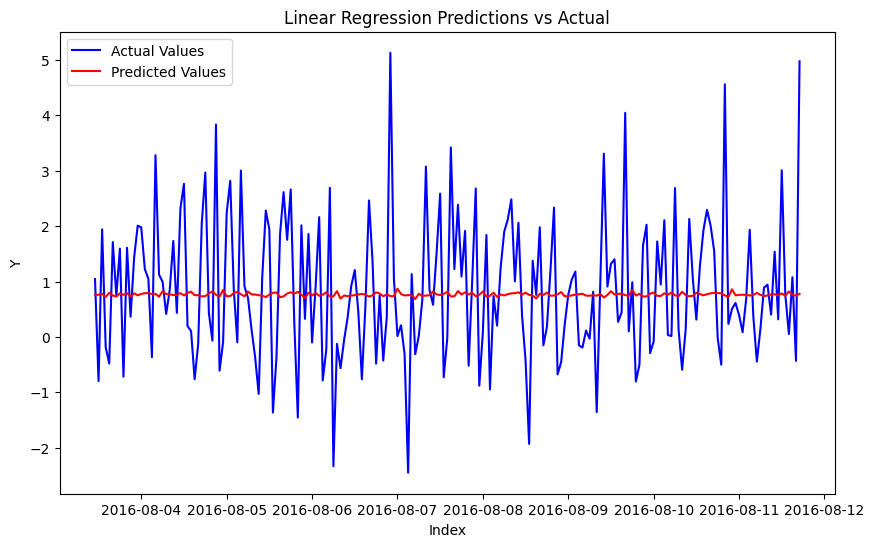

In [40]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load your dataset
data = data_df.copy()  # make sure your data path is correct
Y = data['Y']

# Create lag features
data['Y_lag1'] = Y.shift(1)
data['Y_lag2'] = Y.shift(2)

# Remove NaN values that result from the lag operation
data = data.dropna()

# Define the size of the test set
test_size = int(len(data) * 0.2)  # e.g., 20% of the data as test set

# Split the data by index
train_data = data[:-test_size]
test_data = data[-test_size:]

# Define features and target
X_train = train_data[['Y_lag1', 'Y_lag2']]
Y_train = train_data['Y']
X_test = test_data[['Y_lag1', 'Y_lag2']]
Y_test = test_data['Y']

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# Predict on the test set
Y_pred = model.predict(X_test)

# Calculate error metrics
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)

# Print error metrics
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(Y_test.index, Y_test, label='Actual Values', color='blue')
plt.plot(Y_test.index, Y_pred, label='Predicted Values', color='red')
plt.title('Linear Regression Predictions vs Actual')
plt.xlabel('Index')
plt.ylabel('Y')
plt.legend()
plt.show()


In [98]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load your dataset
data = data_df  # Update path as necessary

# Select features and target
X = data[['X', 'C']]
Y = data['Y']

# Define the size of the test set
test_size = int(len(data) * 0.2)  # e.g., 20% of the data as test set

# Split the data by index for a time series prediction context
train_data = data.iloc[:-test_size]
test_data = data.iloc[-test_size:]

X_train = train_data[['X', 'C']]
Y_train = train_data['Y']
X_test = test_data[['X', 'C']]
Y_test = test_data['Y']

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# Predict on the test set
Y_pred = model.predict(X_test)

# Calculate error metrics
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)

# Print error metrics
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(Y_test.index, Y_test, label='Actual Values', color='blue')
plt.plot(Y_test.index, Y_pred, label='Predicted Values', color='red')
plt.title('Linear Regression Predictions vs Actual with Features X and C')
plt.xlabel('Index')
plt.ylabel('Y')
plt.legend()
plt.show()


KeyError: "None of [Index(['X', 'C'], dtype='object')] are in the [columns]"

In [78]:
data_df

,date,0,1,OT
0,2016-07-01 02:00:00,0.319940,0.219588,1.196932
1,2016-07-01 03:00:00,0.385308,-0.497375,1.006739
2,2016-07-01 04:00:00,-0.942470,-1.360758,1.398245
3,2016-07-01 05:00:00,0.104528,-0.783378,1.634444
4,2016-07-01 06:00:00,0.792911,0.258154,-0.045223
...,...,...,...,...
995,2016-08-11 13:00:00,0.406236,-0.068060,-0.428902
996,2016-08-11 14:00:00,1.882956,0.121554,0.905303
997,2016-08-11 15:00:00,1.659560,-0.229964,1.616727
998,2016-08-11 16:00:00,0.558850,-0.733833,1.032354


In [77]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
data = 0
# Load your dataset
data = data_df  # Update path as necessary

# Select features and target
X = data[['X', 'C']]
Y = data['Y']

# Define the size of the test set
test_size = int(len(data) * 0.2)  # e.g., 20% of the data as test set

# Split the data by index for a time series prediction context
train_data = data.iloc[:-test_size]
test_data = data.iloc[-test_size:]

X_train = train_data[['X', 'C']]
Y_train = train_data['Y']
X_test = test_data[['X', 'C']]
Y_test = test_data['Y']

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# Predict on the test set
Y_pred = model.predict(X_test)

# Calculate error metrics
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)

# Print error metrics
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(Y_test.index, Y_test, label='Actual Values', color='blue')
plt.plot(Y_test.index, Y_pred, label='Predicted Values', color='red')
plt.title('Linear Regression Predictions vs Actual with Features X and C')
plt.xlabel('Index')
plt.ylabel('Y')
plt.legend()
plt.show()


KeyError: "None of [Index(['X', 'C'], dtype='object')] are in the [columns]"

In [43]:
data_df3

,date,0,1,2,3,OT
0,2016-07-01 02:00:00,-0.352822,-0.409858,-0.505936,0.083544,0.441378
1,2016-07-01 03:00:00,0.392530,0.225523,1.092889,0.121622,1.896103
2,2016-07-01 04:00:00,1.291451,0.933349,1.102326,0.125796,-0.135328
3,2016-07-01 05:00:00,-0.570826,-0.627299,-0.350626,0.305134,1.048835
4,2016-07-01 06:00:00,0.617017,0.682011,-0.099283,0.121796,0.405358
...,...,...,...,...,...,...
2995,2016-11-02 21:00:00,-0.296730,-0.121767,-0.838905,-0.241487,2.004070
2996,2016-11-02 22:00:00,0.107100,-0.007417,1.050701,0.006618,0.624499
2997,2016-11-02 23:00:00,1.084363,0.872346,-0.552176,0.109519,1.832230
2998,2016-11-03 00:00:00,-1.829897,-0.981977,-0.609478,-0.133088,0.752449


Mean Squared Error: 0.7593857994063179
Mean Absolute Error: 0.6953434450126695


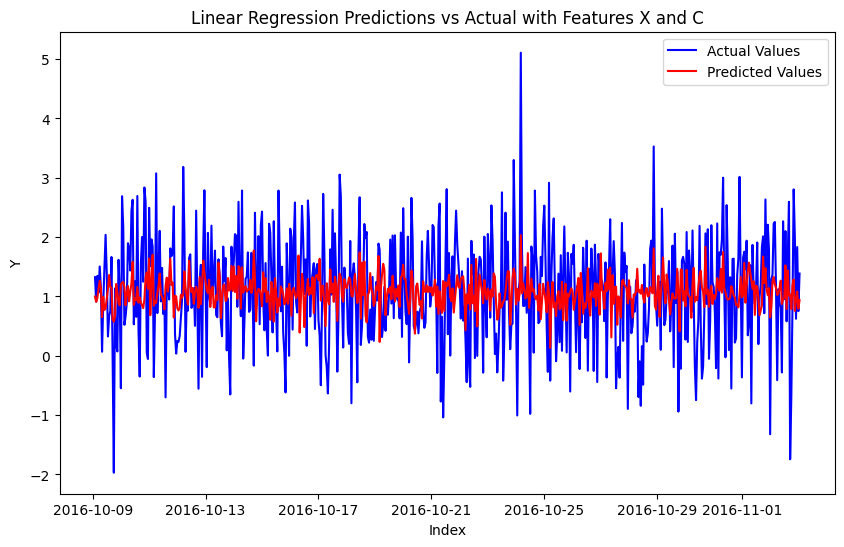

In [46]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
data = 0
# Load your dataset
data = data_df3  # Update path as necessary

# Select features and target
X = data[["0","1","2","3"]]
Y = data['OT']

# Define the size of the test set
test_size = int(len(data) * 0.2)  # e.g., 20% of the data as test set

# Split the data by index for a time series prediction context
train_data = data.iloc[:-test_size]
test_data = data.iloc[-test_size:]

X_train = train_data[["0","1","2","3"]]
Y_train = train_data['OT']
X_test = test_data[["0","1","2","3"]]
Y_test = test_data['OT']

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# Predict on the test set
Y_pred = model.predict(X_test)

# Calculate error metrics
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)

# Print error metrics
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(Y_test.index, Y_test, label='Actual Values', color='blue')
plt.plot(Y_test.index, Y_pred, label='Predicted Values', color='red')
plt.title('Linear Regression Predictions vs Actual with Features X and C')
plt.xlabel('Index')
plt.ylabel('Y')
plt.legend()
plt.show()


OLD:

In [1]:
import numpy as np
import pandas as pd
from datasets import DatasetDict, Dataset

def generate_complex_data(n_samples=20, seq_length=1000): #(n_samples=862, seq_length=17544):
    # Generate the confounder C
    C = np.random.normal(loc=0, scale=1, size=n_samples)
    
    data = []
    for i in range(n_samples):
        # X is influenced by C
        X = np.sin(C[i]) + np.random.normal(loc=0, scale=0.2, size=seq_length)
        # Y is influenced by X and C in a non-linear way
        Y = np.square(X) + np.cos(C[i]) + np.random.normal(loc=0, scale=0.2, size=seq_length)
        
        item = {
            'start': pd.Period('2015-01-01 00:00', freq='H').strftime('%Y-%m-%d %H:%M'),
            'target': Y.tolist(),
            'feat_static_cat': [i],
            'feat_dynamic_real': None,
            'item_id': f'T{i+1}'
        }
        data.append(item)
    
    return data

# Generate the test dataset with the maximum length
test_data = generate_complex_data(seq_length=1000)

# Create the validation dataset by removing the last 48 elements from each target sequence
validation_data = [{**item, 'target': item['target'][:-48]} for item in test_data]

# Create the train dataset by removing the last 96 elements from each target sequence
train_data = [{**item, 'target': item['target'][:-96]} for item in test_data]

# Create the DatasetDict
dataset_dict = DatasetDict({
    'train': Dataset.from_list(train_data),
    'validation': Dataset.from_list(validation_data),
    'test': Dataset.from_list(test_data)
})

# Print the dataset structure
print(dataset_dict)

# Access an example from the train dataset
print(dataset_dict['train'][0])

c:\Users\florisschouw\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 20
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 20
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 20
    })
})
{'start': '2015-01-01 00:00', 'target': [1.7498655105034728, 1.0408262439097655, 1.1505409109563292, 1.2627998146258197, 1.238665299384904, 1.3301700691138518, 1.0123280313774812, 1.4308180130979427, 1.2262508245770178, 1.3409557683246331, 0.8814832444151004, 1.2497933010890205, 1.263116596167181, 0.7884447724249355, 1.3843831872058923, 1.2861955411856403, 0.9774263609314559, 1.5375537780481667, 1.330914945207989, 0.9265989419078962, 0.9801024042930833, 1.4303072720791095, 1.2385973315265868, 1.028544063060652, 0.944190692185495, 0.9978577024601392, 1.4141